In [4]:
import wrds
import pandas as pd
import datetime

# Connect to WRDS
db = wrds.Connection()

Enter your WRDS username [tonyd]:apappas
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [5]:
# Function to get S&P 500 and company returns
def get_sp500_and_company_returns():
    # Get the list of S&P 500 companies
    sp500_constituents = db.get_table('comp', 'idxcst_his', columns=['gvkey', 'iid', '"from"', '"thru"'])
    sp500_constituents = sp500_constituents[sp500_constituents['iid'] == '01']
    
    # Get the S&P 500 index returns
    sp500_returns = db.raw_sql("""
        SELECT caldt AS date, vwretd AS ret
        FROM crsp.dsp500
        WHERE caldt BETWEEN '2000-01-01' AND '2010-12-31'
    """)
    
    # Filter for Wednesdays
    sp500_returns['date'] = pd.to_datetime(sp500_returns['date'])
    sp500_returns = sp500_returns[sp500_returns['date'].dt.weekday == 2]
    
    # Initialize an empty DataFrame
    df = pd.DataFrame(columns=['Ticker', 'Date', 'Company Return', 'S&P 500 Return'])
    
    # Loop through each company in the S&P 500
    for _, row in sp500_constituents.iterrows():
        gvkey = row['gvkey']
        
        # Get the lpermno for the gvkey
        permno_data = db.raw_sql(f"""
            SELECT lpermno
            FROM crsp.ccmxpf_linktable
            WHERE gvkey = '{gvkey}' AND linktype IN ('LU', 'LC') AND
                  linkdt <= '2010-12-31' AND (linkenddt IS NULL OR linkenddt >= '2000-01-01')
        """)
        
        if permno_data.empty:
            continue
        
        lpermno = int(permno_data.iloc[0]['lpermno'])
        
        # Get the company returns
        company_returns = db.raw_sql(f"""
            SELECT date, ret
            FROM crsp.dsf
            WHERE permno = {lpermno} AND date BETWEEN '2000-01-01' AND '2010-12-31'
        """)
        
        # Filter for Wednesdays
        company_returns['date'] = pd.to_datetime(company_returns['date'])
        company_returns = company_returns[company_returns['date'].dt.weekday == 2]
        
        # Merge with S&P 500 returns
        merged = pd.merge(company_returns, sp500_returns, on='date', suffixes=('_company', '_sp500'))
        merged['Ticker'] = gvkey
        merged = merged[['Ticker', 'date', 'ret_company', 'ret_sp500']]
        merged.columns = ['Ticker', 'Date', 'Company Return', 'S&P 500 Return']
        
        # Append to the main DataFrame
        df = pd.concat([df, merged])
    
    return df

# Get the DataFrame
df = get_sp500_and_company_returns()
print(df)

C:\Users\tonyd\AppData\Local\Temp\ipykernel_33736\319861338.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, merged])


    Ticker       Date  Company Return  S&P 500 Return
0   001013 2000-01-05       -0.030710        0.000852
1   001013 2000-01-12        0.036483       -0.004256
2   001013 2000-01-19       -0.013457        0.001418
3   001013 2000-01-26       -0.067708       -0.005067
4   001013 2000-02-02        0.002715       -0.000552
..     ...        ...             ...             ...
22  184996 2010-12-01       -0.027739        0.021595
23  184996 2010-12-08        0.025665        0.003878
24  184996 2010-12-15        0.037504       -0.004986
25  184996 2010-12-22        0.011469        0.003422
26  184996 2010-12-29        0.049981        0.001216

[228563 rows x 4 columns]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228563 entries, 0 to 26
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Ticker          228563 non-null  object        
 1   Date            228563 non-null  datetime64[ns]
 2   Company Return  227533 non-null  float64       
 3   S&P 500 Return  228563 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 8.7+ MB


In [33]:
import datetime
import statsmodels.api as sm

def calculate_betas(df):
    df['Year'] = df['Date'].dt.year
    betas = []

    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker]
        for year in ticker_data['Year'].unique():
            yearly_data = ticker_data[ticker_data['Year'] == year]
            if len(yearly_data) > 1:  # Ensure there is enough data to perform regression
                X = sm.add_constant(yearly_data['S&P 500 Return'])
                y = yearly_data['Company Return']
                model = sm.OLS(y, X).fit()
                beta = model.params['S&P 500 Return']
                betas.append({'Ticker': ticker, 'Year': year, 'Beta': beta})
    
    beta_df = pd.DataFrame(betas)
    return beta_df

# Calculate the betas
beta_df = calculate_betas(df)
beta_df

KeyboardInterrupt: 

In [37]:
FundRatios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573102 entries, 0 to 573101
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   bm           546542 non-null  float64
 1   cfm          545741 non-null  float64
 2   roe          537261 non-null  float64
 3   debt_ebitda  566180 non-null  float64
 4   inv_turn     406536 non-null  float64
 5   rect_turn    536909 non-null  float64
 6   pay_turn     552105 non-null  float64
 7   Year         573102 non-null  int32  
 8   Ticker       573102 non-null  int64  
dtypes: float64(7), int32(1), int64(1)
memory usage: 37.2 MB


In [44]:
beta_df['Ticker'] = beta_df['Ticker'].astype(int)
FundRatios= pd.read_csv('FundamentalRatios.csv')
FundRatios['public_date'] = pd.to_datetime(FundRatios['public_date']).dt.year
FundRatios['Year']=FundRatios['public_date']
FundRatios['Ticker']=FundRatios['gvkey']
FundRatios.drop('adate', axis=1, inplace=True)
FundRatios.drop('qdate', axis=1, inplace=True)
FundRatios.drop('public_date', axis=1, inplace=True)
FundRatios.drop('gvkey', axis=1, inplace=True)
dfmerge = pd.merge(FundRatios, beta_df, on=['Year', 'Ticker'])
dfmerge.dropna(inplace=True)
dfmerge.reset_index()
dfmerge

,gpm,cfm,roe,debt_ebitda,inv_turn,rect_turn,pay_turn,Year,Ticker,Beta
0,0.517,0.098,0.081,0.112,4.433,4.801,10.713,2000,1013,1.463464
1,0.517,0.098,0.081,0.112,4.433,4.801,10.713,2000,1013,1.463464
2,0.468,0.113,0.133,0.167,5.108,5.995,13.463,2000,1013,1.463464
3,0.468,0.113,0.133,0.167,5.108,5.995,13.463,2000,1013,1.463464
4,0.468,0.113,0.133,0.167,5.108,5.995,13.463,2000,1013,1.463464
...,...,...,...,...,...,...,...,...,...,...
40387,0.752,0.244,0.549,0.000,6.464,5.390,6.768,2010,183377,1.062764
40388,0.752,0.244,0.549,0.000,6.464,5.390,6.768,2010,183377,1.062764
40389,0.752,0.244,0.549,0.000,6.464,5.390,6.768,2010,183377,1.062764
40390,0.752,0.248,0.583,0.000,6.806,5.360,6.904,2010,183377,1.062764


Mean Squared Error: 0.14508663192800067
             Coefficient
gpm            -0.000613
cfm            -0.000523
roe            -0.054366
debt_ebitda    -0.000017
inv_turn        0.000134
pay_turn       -0.002671
rect_turn       0.000006


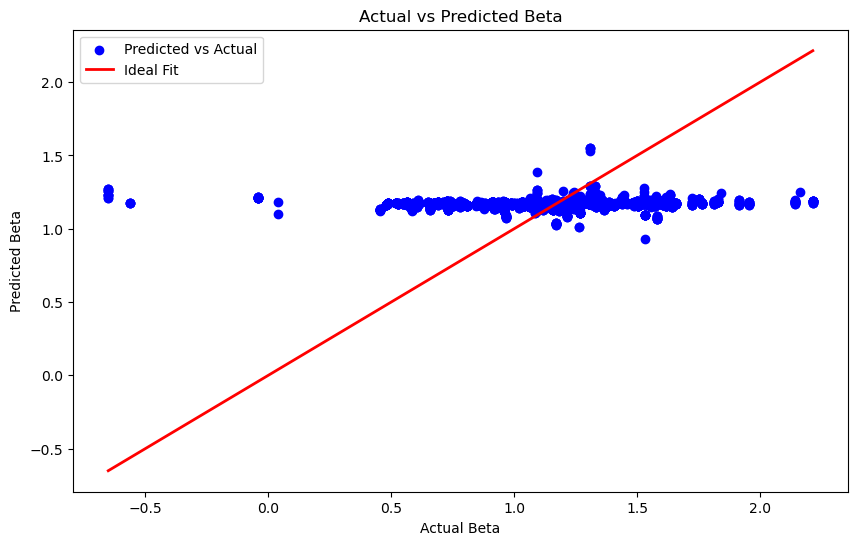

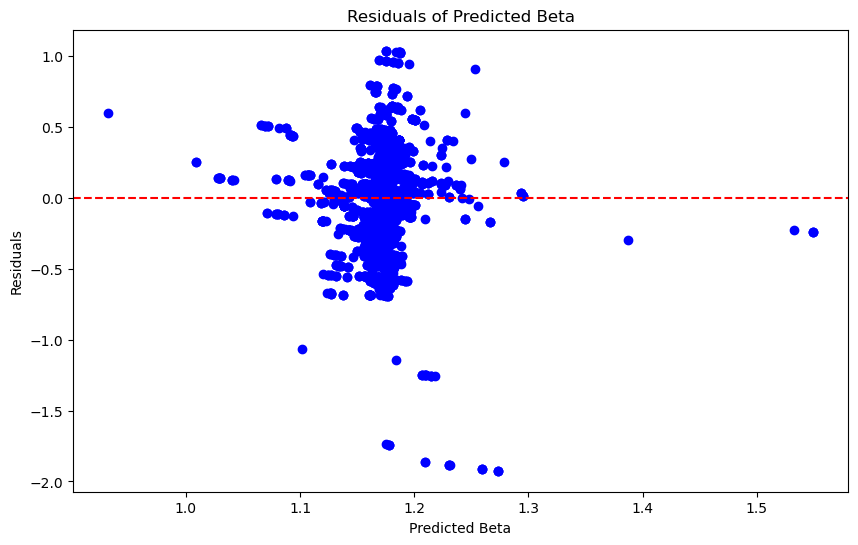

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Split the data into training and testing sets based on the year
train_df = dfmerge[dfmerge['Year'] <= 2009]
test_df = dfmerge[dfmerge['Year'] == 2010]

# Define the features (X) and target (y)
X_train = train_df[['gpm', 'cfm', 'roe', 'debt_ebitda', 'inv_turn', 'pay_turn', 'rect_turn']]
y_train = train_df['Beta']

X_test = test_df[['gpm', 'cfm', 'roe', 'debt_ebitda', 'inv_turn', 'pay_turn', 'rect_turn']]
y_test = test_df['Beta']

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Print the coefficients of the model
coefficients = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient'])
print(coefficients)

# Visualization of the model showing the error of the predicted beta
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Ideal Fit')
plt.xlabel('Actual Beta')
plt.ylabel('Predicted Beta')
plt.title('Actual vs Predicted Beta')
plt.legend()
plt.show()

# Plotting the residuals (errors)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Beta')
plt.ylabel('Residuals')
plt.title('Residuals of Predicted Beta')
plt.show()